In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import requests
import zipfile
import json
import io, os
import sys
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
import urllib.parse as urlparse
from urllib.parse import parse_qs
from collections import Counter

# Export data from Qualtrics

In [ ]:
def exportSurvey(apiToken,surveyId, dataCenter, fileFormat):

    surveyId = surveyId
    fileFormat = fileFormat
    dataCenter = dataCenter 

    # Setting static parameters
    requestCheckProgress = 0.0
    progressStatus = "inProgress"
    baseUrl = "https://{0}.qualtrics.com/API/v3/surveys/{1}/export-responses/".format(dataCenter, surveyId)
    headers = {
    "content-type": "application/json",
    "x-api-token": apiToken,
    }

    # Step 1: Creating Data Export
    downloadRequestUrl = baseUrl
    downloadRequestPayload = '{"format":"' + fileFormat + '"}'
    downloadRequestResponse = requests.request("POST", downloadRequestUrl, data=downloadRequestPayload, headers=headers)
    progressId = downloadRequestResponse.json()["result"]["progressId"]
    print(downloadRequestResponse.text)

    # Step 2: Checking on Data Export Progress and waiting until export is ready
    while progressStatus != "complete" and progressStatus != "failed":
        print ("progressStatus=", progressStatus)
        requestCheckUrl = baseUrl + progressId
        requestCheckResponse = requests.request("GET", requestCheckUrl, headers=headers)
        requestCheckProgress = requestCheckResponse.json()["result"]["percentComplete"]
        print("Download is " + str(requestCheckProgress) + " complete")
        progressStatus = requestCheckResponse.json()["result"]["status"]

    #step 2.1: Check for error
    if progressStatus == "failed":
        raise Exception("export failed")

    fileId = requestCheckResponse.json()["result"]["fileId"]

    # Step 3: Downloading file
    requestDownloadUrl = baseUrl + fileId + '/file'
    requestDownload = requests.request("GET", requestDownloadUrl, headers=headers, stream=True)

    # Step 4: Unzipping the file
    zipfile.ZipFile(io.BytesIO(requestDownload.content)).extractall("/content/drive/MyDrive/W241 Team Water/QualtricsDownload")
    print('Complete')

In [ ]:
os.environ['APIKEY'] = "JBlYMYYPRLoybZpJrVbSIXinoynsR5d4u8RuWaNP"
os.environ['DATACENTER'] = "ca1"
#surveyId = 'SV_0O22acv1BCoQ7NI' #Draft - Pre-experimental Survey - 06/16/2021
surveyId = 'SV_7NA1AZ7hVB8CZUi' #Final - Pre-experimental Survey
fileFormat = 'csv'

apiToken = os.environ['APIKEY']
dataCenter = os.environ['DATACENTER']

In [ ]:
exportSurvey(apiToken, surveyId, dataCenter, fileFormat)

{"result":{"progressId":"ES_elmzvvWpyPwK2fI","percentComplete":0.0,"status":"inProgress"},"meta":{"requestId":"9c65b5cc-ea1f-4df2-9ae7-f6a7af0c5b62","httpStatus":"200 - OK"}}
progressStatus= inProgress
Download is 0.0 complete
progressStatus= inProgress
Download is 0.0 complete
progressStatus= inProgress
Download is 36.76470588235294 complete
progressStatus= inProgress
Download is 36.76470588235294 complete
progressStatus= inProgress
Download is 100.0 complete
Complete


# Read as Pandas Dataframe and Inspect

In [ ]:
# Read as Pandas Dataframe
#df = pd.read_csv("/content/drive/MyDrive/W241 Team Water/MyQualtricsDownload/Draft - Pre-experimental Survey - 06/16/2021.csv")
df = pd.read_csv("/content/drive/MyDrive/W241 Team Water/QualtricsDownload/Final - Pre-experimental Survey.csv")

print("Shape of data:", df.shape)
df.head(10)

Shape of data: (274, 56)


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q_RecaptchaScore,Q_RecaptchaAssessmentName,Q_RelevantIDDuplicate,Q_RelevantIDDuplicateScore,Q_RelevantIDFraudScore,Q_RelevantIDLastStartDate,Q_BallotBoxStuffing,Age,Gender,Q14,Q15,Instructions,COMMON ITEM,Common Question 2,Q38,Q39,Q40,Q41,Q47,Q49,Q56,Q57,ITEM NAME,Q29,Q42,Q44,Q45,Q46,Q50,Q51,Q52,Q53,Q54,Q55,Email,RandomID,ReferURL,Email - Parent Topics,Email - Topics
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,Recipient First Name,Recipient Email,External Data Reference,Location Latitude,Location Longitude,Distribution Channel,User Language,Q_RecaptchaScore,Q_RecaptchaAssessmentName,Q_RelevantIDDuplicate,Q_RelevantIDDuplicateScore,Q_RelevantIDFraudScore,Q_RelevantIDLastStartDate,Q_BallotBoxStuffing,What is your age range?,What gender do you identify as?,Which of the following best describes your emp...,What is your marital status?,Assume that you are interested in purchasing t...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Assume that you're interested in buying this i...,Please provide your email address to be entere...,RandomID,ReferURL,Email - Parent Topics,Email - Topics
1,"{""ImportId"":""startDate"",""timeZone"":""Z""}","{""ImportId"":""endDate"",""timeZone"":""Z""}","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""Z""}","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}","{""ImportId"":""recipientFirstName""}","{""ImportId"":""recipientEmail""}","{""ImportId"":""externalDataReference""}","{""ImportId"":""locationLatitude""}","{""ImportId"":""locationLongitude""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""Q_RecaptchaScore""}","{""ImportId"":""Q_RecaptchaAssessmentName""}","{""ImportId"":""Q_RelevantIDDuplicate""}","{""ImportId"":""Q_RelevantIDDuplicateScore""}","{""ImportId"":""Q_RelevantIDFraudScore""}","{""ImportId"":""Q_RelevantIDLastStartDate"",""timeZ...","{""ImportId"":""Q_BallotBoxStuffing""}","{""ImportId"":""QID8""}","{""ImportId"":""QID10""}","{""ImportId"":""QID24""}","{""ImportId"":""QID25""}","{""ImportId"":""QID19""}","{""ImportId"":""QID17_TEXT""}","{""ImportId"":""QID59_TEXT""}","{""ImportId"":""QID38_TEXT""}","{""ImportId"":""QID39_TEXT""}","{""ImportId"":""QID40_TEXT""}","{""ImportId"":""QID41_TEXT""}","{""ImportId"":""QID47_TEXT""}","{""ImportId"":""QID49_TEXT""}","{""ImportId"":""QID56_TEXT""}","{""ImportId"":""QID57_TEXT""}","{""ImportId"":""QID18_TEXT""}","{""ImportId"":""QID29_TEXT""}","{""ImportId"":""QID42_TEXT""}","{""ImportId"":""QID44_TEXT""}","{""ImportId"":""QID45_TEXT""}",

In [ ]:
# Summary Stats
df.describe(include='all')

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q_RecaptchaScore,Q_RecaptchaAssessmentName,Q_RelevantIDDuplicate,Q_RelevantIDDuplicateScore,Q_RelevantIDFraudScore,Q_RelevantIDLastStartDate,Q_BallotBoxStuffing,Age,Gender,Q14,Q15,Instructions,COMMON ITEM,Common Question 2,Q38,Q39,Q40,Q41,Q47,Q49,Q56,Q57,ITEM NAME,Q29,Q42,Q44,Q45,Q46,Q50,Q51,Q52,Q53,Q54,Q55,Email,RandomID,ReferURL,Email - Parent Topics,Email - Topics
count,274,274,274,273,274,274,274,274,274,2,2,2,2,250,250,274,274,270,2,11,273,273,11,10,269,269,268,268,261,254,256,123,133,109,147,132,124,132,123,144,113,115,141,131,125,114,141,135,120,131,125,217,274,274,2,22
unique,271,272,4,254,14,177,4,254,274,2,2,2,2,209,211,5,3,15,2,3,5,9,11,3,9,5,7,5,3,33,11,18,16,19,23,16,20,17,16,15,14,15,14,16,19,20,22,14,15,20,17,217,274,30,2,3
top,2021-06-30 15:50:33,2021-06-30 22:24:40,0,172.85.200.202,100,153,1,2021-07-06 04:15:42,R_2wAdaEJuucpryaQ,Recipient Last Name,Recipient First Name,Recipient Email,"{""ImportId"":""externalDataReference""}",38.920806884765625,-77.03600311279296875,anonymous,EN,1,Q_RecaptchaAssessmentName,true,0,0,2021-06-29 14:04:54,true,3,6,1,1,7,50,2,10,10,50,50,20,30,40,40,10,10,15,15,5,10,50,50,5,5,10,10,talulamiller@gmail.com,9331063580,https://berkeley.qualtrics.com/jfe/form/SV_7NA...,"{""ImportId"":""QID7_TEXT_adcc34b6e377414294e748e...",Unknown
freq,2,2,271,3,248,6,248,9,1,1,1,1,1,5,5,269,272,115,1,9,262,260,1,8,195,154,223,194,259,47,57,28,37,28,29,27,20,26,24,54,37,36,43,33,38,29,26,51,48,36,33,1,1,196,1,20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   StartDate                   274 non-null    object
 1   EndDate                     274 non-null    object
 2   Status                      274 non-null    object
 3   IPAddress                   273 non-null    object
 4   Progress                    274 non-null    object
 5   Duration (in seconds)       274 non-null    object
 6   Finished                    274 non-null    object
 7   RecordedDate                274 non-null    object
 8   ResponseId                  274 non-null    object
 9   RecipientLastName           2 non-null      object
 10  RecipientFirstName          2 non-null      object
 11  RecipientEmail              2 non-null      object
 12  ExternalReference           2 non-null      object
 13  LocationLatitude            250 non-null    object

# Data Cleaning

In [ ]:
final_columns = ['StartDate', 'EndDate', 'Status','Duration (in seconds)', 
                 'Finished', 'ResponseId', 'DistributionChannel', 'Age', 'Gender', 
                 'Q14', 'Q15', 'COMMON ITEM', 'Common Question 2', 'Q38', 'Q39', 
                 'Q40', 'Q41', 'Q47', 'Q49', 'Q56', 'Q57', 'ITEM NAME', 'Q29', 
                 'Q42', 'Q44', 'Q45', 'Q46', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54', 
                 'Q55', 'Email', 'RandomID', 'ReferURL']

In [ ]:
#Question to Item Mapping
q_item_map = dict({'Age':'age',
                   'Gender':'gender',
                   'Duration (in seconds)':'duration',
                   'Q14':'employment',
                   'Q15':'marital', 
                   'COMMON ITEM':'vacuum',
                   'Common Question 2':'towel_hook',
                    'Q38':'knife_set_0',
                    'Q39':'knife_set_1',
                    'Q40':'office_chair_0',
                    'Q41':'office_chair_1',
                    'Q47':'trash_0',
                    'Q49':'trash_1',
                    'Q56':'area_rug_0',
                    'Q57':'area_rug_1',
                    'ITEM NAME':'weight_scale_0',
                    'Q29':'weight_scale_1',
                    'Q42':'laptop_stand_0',
                    'Q44':'laptop_stand_1',
                    'Q45':'fanny_pack_0',
                    'Q46':'fanny_pack_1',
                    'Q50':'mini_fridge_0',
                    'Q51':'mini_fridge_1',
                    'Q52':'book_0',
                    'Q53':'book_1',
                    'Q54':'mixing_bowl_0',
                    'Q55':'mixing_bowl_1'})

#Item to Retail Price Mapping
item_price_map = dict({'vacuum':170,
                   'towel_hook':9,
                    'knife_set_0':25,
                    'knife_set_1':25,
                    'office_chair_0':86,
                    'office_chair_1':86,
                    'trash_0':70,
                    'trash_1':70,
                    'area_rug_0':60,
                    'area_rug_1':60,
                    'weight_scale_0':25,
                    'weight_scale_1':25,
                    'laptop_stand_0':29,
                    'laptop_stand_1':29,
                    'fanny_pack_0':35,
                    'fanny_pack_1':35,
                    'mini_fridge_0':115,
                    'mini_fridge_1':115,
                    'book_0':14,
                    'book_1':14,
                    'mixing_bowl_0':40,
                    'mixing_bowl_1':40})

#Item to Outcome Mapping
item_outcome_map = dict({'knife_set_0':0,
                    'knife_set_1':1,
                    'office_chair_0':0,
                    'office_chair_1':1,
                    'trash_0':0,
                    'trash_1':1,
                    'area_rug_0':0,
                    'area_rug_1':1,
                    'weight_scale_0':0,
                    'weight_scale_1':1,
                    'laptop_stand_0':0,
                    'laptop_stand_1':1,
                    'fanny_pack_0':0,
                    'fanny_pack_1':1,
                    'mini_fridge_0':0,
                    'mini_fridge_1':1,
                    'book_0':0,
                    'book_1':1,
                    'mixing_bowl_0':0,
                    'mixing_bowl_1':1})

# Select Final Rows

In [ ]:
# Drop first two rows with headers labels (th)
df_new = df.drop(index=[0,1]) 

# Only keep columns specified above
df_new = df_new[final_columns]

# Rename columns
df_new.rename(columns=q_item_map, inplace=True)

# Assign column types
df_new["duration"] = df_new["duration"].astype(int)  # convert Duration column to int type

In [ ]:
df_new.head()

,StartDate,EndDate,Status,duration,Finished,ResponseId,DistributionChannel,age,gender,employment,marital,vacuum,towel_hook,knife_set_0,knife_set_1,office_chair_0,office_chair_1,trash_0,trash_1,area_rug_0,area_rug_1,weight_scale_0,weight_scale_1,laptop_stand_0,laptop_stand_1,fanny_pack_0,fanny_pack_1,mini_fridge_0,mini_fridge_1,book_0,book_1,mixing_bowl_0,mixing_bowl_1,Email,RandomID,ReferURL
2,2021-06-28 14:52:32,2021-06-28 14:55:02,0,150,1,R_0TKvPPK0Cqk0bEl,anonymous,2,5,1,1,140,5,NaN,15,40,NaN,NaN,30,NaN,30,10,NaN,NaN,20,NaN,25,80,NaN,NaN,10,NaN,20,Nathan.nusaputra@yahoo.com,6106505790,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
3,2021-06-28 14:57:53,2021-06-28 15:00:08,0,135,1,R_2aP3icVaLbmetoa,anonymous,3,6,1,2,50,1,NaN,10,25,NaN,25,NaN,NaN,10,5,NaN,NaN,5,NaN,5,NaN,30,3,NaN,NaN,5,Sumeim415@hotmail.com,1674527230,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
4,2021-06-28 15:09:21,2021-06-28 15:11:04,0,102,1,R_RrgDyFfkJJz7GxP,anonymous,3,5,2,2,100,2,5,NaN,30,NaN,30,NaN,NaN,30,NaN,10,15,NaN,15,NaN,NaN,40,NaN,5,5,NaN,bentheshortall@hotmail.com,4257457518,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
5,2021-06-28 15:14:15,2021-06-28 15:22:11,0,475,1,R_1CBE8sEbNKs14Iu,anonymous,3,5,1,2,100,5,NaN,20,50,NaN,NaN,50,50,NaN,NaN,15,NaN,20,5,NaN,NaN,75,NaN,5,NaN,10,ronniechu8@gmail.com,2097941144,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
6,2021-06-28 15:24:40,2021-06-28 15:27:25,0,165,1,R_22xnoqyDHNlSLyE,anonymous,3,5,1,2,40,2,NaN,15,NaN,25,NaN,15,25,NaN,15,NaN,NaN,15,NaN,20,50,NaN,3,NaN,NaN,10,unklekoolio@yahoo.com,8754758954,https://berkeley.qualtrics.com/jfe/form/SV_7NA...


In [ ]:
# Delete Rows with duplicated email addresses (keep first attempt)
df_1 = df_new.drop_duplicates(subset=['Email'], keep='first')   #dataframe with duplicate emails dropped (keeping first attempt only)

# Remove the null email in df_1
df_1_ = df_1[~df_1.Email.isnull()]
df_2 = df_new[df_new.Email.isnull()] # dataframe with only null emails
df_new = pd.concat([df_1_,df_2]) # merge ^ both dataframes

# Drop any rows that took less than 60 seconds to complete survey
df_new = df_new[df_new["duration"] > 60]  # drop rows where duration took <= 60 seconds

# Dropping any rows that put the same offer price for all items
for idx, row in df_new.iterrows():
  check_offers = set()
  for i in list(item_price_map.keys()):
    check_offers.add(row[i])
  
  if len(check_offers) == 1:
    df_new.drop(index=idx, inplace=True)

# Dropping any rows that did not finish the survey
df_new = df_new[df_new.Finished != "0"] # drop rows where survey was not finished

# Only keep status == 0 rows
df_new = df_new[df_new.Status == '0']

# Reset Index
df_new = df_new.reset_index(drop=True) # reset index
df_new.head()

,StartDate,EndDate,Status,duration,Finished,ResponseId,DistributionChannel,age,gender,employment,marital,vacuum,towel_hook,knife_set_0,knife_set_1,office_chair_0,office_chair_1,trash_0,trash_1,area_rug_0,area_rug_1,weight_scale_0,weight_scale_1,laptop_stand_0,laptop_stand_1,fanny_pack_0,fanny_pack_1,mini_fridge_0,mini_fridge_1,book_0,book_1,mixing_bowl_0,mixing_bowl_1,Email,RandomID,ReferURL
0,2021-06-28 14:52:32,2021-06-28 14:55:02,0,150,1,R_0TKvPPK0Cqk0bEl,anonymous,2,5,1,1,140,5,NaN,15,40,NaN,NaN,30,NaN,30,10,NaN,NaN,20,NaN,25,80,NaN,NaN,10,NaN,20,Nathan.nusaputra@yahoo.com,6106505790,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
1,2021-06-28 14:57:53,2021-06-28 15:00:08,0,135,1,R_2aP3icVaLbmetoa,anonymous,3,6,1,2,50,1,NaN,10,25,NaN,25,NaN,NaN,10,5,NaN,NaN,5,NaN,5,NaN,30,3,NaN,NaN,5,Sumeim415@hotmail.com,1674527230,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
2,2021-06-28 15:09:21,2021-06-28 15:11:04,0,102,1,R_RrgDyFfkJJz7GxP,anonymous,3,5,2,2,100,2,5,NaN,30,NaN,30,NaN,NaN,30,NaN,10,15,NaN,15,NaN,NaN,40,NaN,5,5,NaN,bentheshortall@hotmail.com,4257457518,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
3,2021-06-28 15:14:15,2021-06-28 15:22:11,0,475,1,R_1CBE8sEbNKs14Iu,anonymous,3,5,1,2,100,5,NaN,20,50,NaN,NaN,50,50,NaN,NaN,15,NaN,20,5,NaN,NaN,75,NaN,5,NaN,10,ronniechu8@gmail.com,2097941144,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
4,2021-06-28 15:24:40,2021-06-28 15:27:25,0,165,1,R_22xnoqyDHNlSLyE,anonymous,3,5,1,2,40,2,NaN,15,NaN,25,NaN,15,25,NaN,15,NaN,NaN,15,NaN,20,50,NaN,3,NaN,NaN,10,unklekoolio@yahoo.com,8754758954,https://berkeley.qualtrics.com/jfe/form/SV_7NA...


In [ ]:
# Compare RAW and CLEANED dataframe size
print(len(df))
print(len(df_new))

274
247


In [ ]:
df_new.head()

,StartDate,EndDate,Status,duration,Finished,ResponseId,DistributionChannel,age,gender,employment,marital,vacuum,towel_hook,knife_set_0,knife_set_1,office_chair_0,office_chair_1,trash_0,trash_1,area_rug_0,area_rug_1,weight_scale_0,weight_scale_1,laptop_stand_0,laptop_stand_1,fanny_pack_0,fanny_pack_1,mini_fridge_0,mini_fridge_1,book_0,book_1,mixing_bowl_0,mixing_bowl_1,Email,RandomID,ReferURL
0,2021-06-28 14:52:32,2021-06-28 14:55:02,0,150,1,R_0TKvPPK0Cqk0bEl,anonymous,2,5,1,1,140,5,NaN,15,40,NaN,NaN,30,NaN,30,10,NaN,NaN,20,NaN,25,80,NaN,NaN,10,NaN,20,Nathan.nusaputra@yahoo.com,6106505790,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
1,2021-06-28 14:57:53,2021-06-28 15:00:08,0,135,1,R_2aP3icVaLbmetoa,anonymous,3,6,1,2,50,1,NaN,10,25,NaN,25,NaN,NaN,10,5,NaN,NaN,5,NaN,5,NaN,30,3,NaN,NaN,5,Sumeim415@hotmail.com,1674527230,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
2,2021-06-28 15:09:21,2021-06-28 15:11:04,0,102,1,R_RrgDyFfkJJz7GxP,anonymous,3,5,2,2,100,2,5,NaN,30,NaN,30,NaN,NaN,30,NaN,10,15,NaN,15,NaN,NaN,40,NaN,5,5,NaN,bentheshortall@hotmail.com,4257457518,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
3,2021-06-28 15:14:15,2021-06-28 15:22:11,0,475,1,R_1CBE8sEbNKs14Iu,anonymous,3,5,1,2,100,5,NaN,20,50,NaN,NaN,50,50,NaN,NaN,15,NaN,20,5,NaN,NaN,75,NaN,5,NaN,10,ronniechu8@gmail.com,2097941144,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
4,2021-06-28 15:24:40,2021-06-28 15:27:25,0,165,1,R_22xnoqyDHNlSLyE,anonymous,3,5,1,2,40,2,NaN,15,NaN,25,NaN,15,25,NaN,15,NaN,NaN,15,NaN,20,50,NaN,3,NaN,NaN,10,unklekoolio@yahoo.com,8754758954,https://berkeley.qualtrics.com/jfe/form/SV_7NA...


In [ ]:
# Store cleaned table as csv
df_new.to_csv('/content/drive/MyDrive/W241 Team Water/cleaned_data.csv', index=False)

# Data Processing

In [ ]:
# Duplicate each row from data export 12 times by item name in any particular order
# Use Pandas Melt   https://www.geeksforgeeks.org/python-pandas-melt/
# Unpivots dataframe from wide format to long format (will get us the 12 items per response)
df_clean = pd.melt(df_new, id_vars=['age', 'gender', 'employment', 'marital','vacuum','towel_hook'], value_vars=['knife_set_0', 'knife_set_1', 'office_chair_0',
                                                'office_chair_1', 'trash_0', 'trash_1', 'area_rug_0', 'area_rug_1',
                                                'weight_scale_0', 'weight_scale_1', 'laptop_stand_0', 'laptop_stand_1',
                                                'fanny_pack_0', 'fanny_pack_1', 'mini_fridge_0', 'mini_fridge_1',
                                                'book_0', 'book_1', 'mixing_bowl_0', 'mixing_bowl_1'],
              var_name ='item', value_name ='outcome')


# Add column for retail price that corresponds to each item
df_clean['retail_price'] = df_clean['item'].map(item_price_map)

# Create "photo_quality" column that will be used as the outcome variable
df_clean['photo_quality'] = df_clean['item'].map(item_outcome_map)

# Re-order Columns with new dataframe
df_final = df_clean[['outcome','photo_quality','item','retail_price','vacuum','towel_hook','age','gender','marital','employment']]

In [ ]:
df_clean.head(-5)

,age,gender,employment,marital,vacuum,towel_hook,item,outcome,retail_price,photo_quality
0,2,5,1,1,140,5,knife_set_0,NaN,25,0
1,3,6,1,2,50,1,knife_set_0,NaN,25,0
2,3,5,2,2,100,2,knife_set_0,5,25,0
3,3,5,1,2,100,5,knife_set_0,NaN,25,0
4,3,5,1,2,40,2,knife_set_0,NaN,25,0
...,...,...,...,...,...,...,...,...,...,...
4930,3,6,1,1,40,4,mixing_bowl_1,12,40,1
4931,3,6,1,2,60,2,mixing_bowl_1,10,40,1
4932,3,6,1,2,48,1,mixing_bowl_1,NaN,40,1
4933,3,6,1,1,25,1,mixing_bowl_1,5,40,1


In [ ]:
df_final

,outcome,photo_quality,item,retail_price,vacuum,towel_hook,age,gender,marital,employment
0,NaN,0,knife_set_0,25,140,5,2,5,1,1
1,NaN,0,knife_set_0,25,50,1,3,6,2,1
2,5,0,knife_set_0,25,100,2,3,5,2,2
3,NaN,0,knife_set_0,25,100,5,3,5,2,1
4,NaN,0,knife_set_0,25,40,2,3,5,2,1
...,...,...,...,...,...,...,...,...,...,...
4935,30,1,mixing_bowl_1,40,120,5,3,5,1,1
4936,NaN,1,mixing_bowl_1,40,50,2,3,5,1,1
4937,15,1,mixing_bowl_1,40,70,1,5,5,2,1
4938,10,1,mixing_bowl_1,40,90,2,2,6,1,1


In [ ]:
#Store final table as csv
df_final.to_csv('/content/drive/MyDrive/W241 Team Water/survey_data.csv', index=False)

# Error Analysis

### Perform some EDA and error analysis on df_final

In [ ]:
df_final = pd.read_csv("/content/drive/MyDrive/W241 Team Water/survey_data.csv")
df_final.head()

,outcome,photo_quality,item,retail_price,vacuum,towel_hook,age,gender,marital,employment
0,NaN,0,knife_set_0,25,140,5,2,5,1,1
1,NaN,0,knife_set_0,25,50,1,3,6,2,1
2,5.0,0,knife_set_0,25,100,2,3,5,2,2
3,NaN,0,knife_set_0,25,100,5,3,5,2,1
4,NaN,0,knife_set_0,25,40,2,3,5,2,1


In [ ]:
# Check that number of rows is x20 of raw table
print("Length of Cleaned Data:", len(df_new))
print("Length of Final Data:", len(df_final))
print("4940/250 =", len(df_final)/len(df_new))

# Check that there are only half the number of outcomes (all others are NA)
print("Count of outcome that are not NA:", df_final.outcome.count())

Length of Cleaned Data: 247
Length of Final Data: 4940
4940/250 = 20.0
Count of outcome that are not NA: 2470


In [ ]:
# Check that there are equal number of each item
df_final.groupby('item').count()

,outcome,photo_quality,retail_price,vacuum,towel_hook,age,gender,marital,employment
item,,,,,,,,,
area_rug_0,129,247,247,247,247,247,247,247,247
area_rug_1,118,247,247,247,247,247,247,247,247
book_0,132,247,247,247,247,247,247,247,247
book_1,115,247,247,247,247,247,247,247,247
fanny_pack_0,127,247,247,247,247,247,247,247,247
fanny_pack_1,120,247,247,247,247,247,247,247,247
knife_set_0,121,247,247,247,247,247,247,247,247
knife_set_1,126,247,247,247,247,247,247,247,247
laptop_stand_0,110,247,247,247,247,247,247,247,247


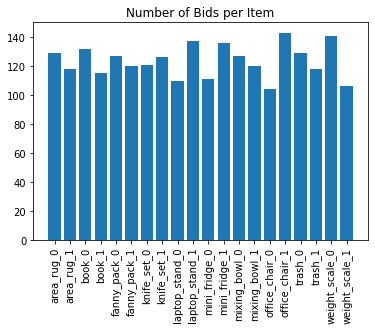

In [ ]:
df_final.groupby('item').count()['outcome']
plt.bar(df_final.groupby('item').count().index,df_final.groupby('item').count()['outcome'])
plt.xticks(rotation=90)
plt.title("Number of Bids per Item")
plt.show()

In [ ]:
df_final.describe()

,outcome,photo_quality,retail_price,vacuum,towel_hook,age,gender,marital,employment
count,2470.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000
mean,23.612146,0.500000,49.900000,78.445344,2.781377,3.032389,5.607287,1.275304,1.340081
std,20.378242,0.500051,30.552888,33.431475,1.788803,0.833935,0.535846,0.464488,0.889600
min,0.000000,0.000000,14.000000,5.000000,0.000000,1.000000,5.000000,1.000000,1.000000
25%,10.000000,0.000000,25.000000,50.000000,1.000000,3.000000,5.000000,1.000000,1.000000
50%,15.000000,0.500000,37.500000,80.000000,3.000000,3.000000,6.000000,1.000000,1.000000
75%,30.000000,1.000000,70.000000,100.000000,4.000000,3.000000,6.000000,2.000000,1.000000
max,115.000000,1.000000,115.000000,150.000000,9.000000,7.000000,9.000000,3.000000,5.000000


In [ ]:
# mean bids per item
df_final.groupby('item').mean()['outcome']

item
area_rug_0        31.271318
area_rug_1        32.338983
book_0             5.075758
book_1             5.913043
fanny_pack_0      11.842520
fanny_pack_1      11.566667
knife_set_0       14.289256
knife_set_1       14.555556
laptop_stand_0    12.890909
laptop_stand_1    14.160584
mini_fridge_0     64.423423
mini_fridge_1     60.845588
mixing_bowl_0     13.984252
mixing_bowl_1     14.016667
office_chair_0    39.663462
office_chair_1    41.482517
trash_0           29.341085
trash_1           29.432203
weight_scale_0    12.141844
weight_scale_1    13.188679
Name: outcome, dtype: float64

In [ ]:
df_final.columns

Index(['outcome', 'photo_quality', 'item', 'retail_price', 'vacuum',
       'towel_hook', 'age', 'gender', 'marital', 'employment'],
      dtype='object')

In [ ]:
df_final

,outcome,photo_quality,item,retail_price,vacuum,towel_hook,age,gender,marital,employment
0,NaN,0,knife_set_0,25,140,5,2,5,1,1
1,NaN,0,knife_set_0,25,50,1,3,6,2,1
2,5.0,0,knife_set_0,25,100,2,3,5,2,2
3,NaN,0,knife_set_0,25,100,5,3,5,2,1
4,NaN,0,knife_set_0,25,40,2,3,5,2,1
...,...,...,...,...,...,...,...,...,...,...
4935,30.0,1,mixing_bowl_1,40,120,5,3,5,1,1
4936,NaN,1,mixing_bowl_1,40,50,2,3,5,1,1
4937,15.0,1,mixing_bowl_1,40,70,1,5,5,2,1
4938,10.0,1,mixing_bowl_1,40,90,2,2,6,1,1


In [ ]:
df_final['gender'].unique()

array([5, 6, 9])

In [ ]:
df_final.groupby(['photo_quality', 'marital']).count()


outcome  item  retail_price  ...   age  gender  employment
photo_quality marital                               ...                          
0             1            918  1810          1810  ...  1810    1810        1810
              2            306   640           640  ...   640     640         640
              3              7    20            20  ...    20      20          20
1             1            892  1810          1810  ...  1810    1810        1810
              2            334   640           640  ...   640     640         640
              3             13    20            20  ...    20      20          20

[6 rows x 8 columns]

In [ ]:
# AGE:        1:Below 18, 2:18-24, 3:25-34, 4:35-44, 5:45-54, 6:Above 55, 7: Prfer not to say
# GENDER:     1:Male, 2:Female, 3:Non-binary, 4:Prefer not to say
# EMPLOYMENT: 1:Full-Time, 2:Part-time, 3:Unemployed, 4:Full-time Student, 5:Prefernot to say
# #MARITAL:   1:Single, 2:Married, 3:Prefer not to say

# number of responses per demographic column
print(df_final.groupby('age').count()['outcome'])
print("")
print(df_final.groupby('gender').count()['outcome'])
print("")
print(df_final.groupby('marital').count()['outcome'])
print("")
print(df_final.groupby('employment').count()['outcome'])


# percent of responses per demographic column
# print(df_final.groupby('age').count()['outcome']/sum(df_final.groupby('age').count()['outcome']))
# print("")
# print(df_final.groupby('gender').count()['outcome']/sum(df_final.groupby('gender').count()['outcome']))
# print("")
# print(df_final.groupby('marital').count()['outcome']/sum(df_final.groupby('marital').count()['outcome']))
# print("")
# print(df_final.groupby('employment').count()['outcome']/sum(df_final.groupby('employment').count()['outcome']))


df_final.groupby(['photo_quality', 'age']).count()


age
1      20
2     390
3    1810
4      90
5      70
6      80
7      10
Name: outcome, dtype: int64

gender
5    1000
6    1460
9      10
Name: outcome, dtype: int64

marital
1    1810
2     640
3      20
Name: outcome, dtype: int64

employment
1    2100
2     100
3     100
4     140
5      30
Name: outcome, dtype: int64


outcome  item  retail_price  ...  gender  marital  employment
photo_quality age                               ...                             
0             1         10    20            20  ...      20       20          20
              2        187   390           390  ...     390      390         390
              3        911  1810          1810  ...    1810     1810        1810
              4         43    90            90  ...      90       90          90
              5         34    70            70  ...      70       70          70
              6         42    80            80  ...      80       80          80
              7          4    10            10  ...      10       10          10
1             1         10    20            20  ...      20       20          20
              2        203   390           390  ...     390      390         390
              3        899  1810          1810  ...    1810     1810        1810
              4         47    90            90  ...      90       90          90
              5         36    70            70  ...      70       70          70
              6         38    80            80  ...      80       80          80
              7          6    10            10  ...      10       10          10

[14 rows x 8 columns]

# Survey Prize Winners

In [ ]:
data_prize_winners = pd.read_csv("/content/drive/MyDrive/W241 Team Water/cleaned_data.csv")
data_prize_winners.head()

,StartDate,EndDate,Status,duration,Finished,ResponseId,DistributionChannel,age,gender,employment,marital,vacuum,towel_hook,knife_set_0,knife_set_1,office_chair_0,office_chair_1,trash_0,trash_1,area_rug_0,area_rug_1,weight_scale_0,weight_scale_1,laptop_stand_0,laptop_stand_1,fanny_pack_0,fanny_pack_1,mini_fridge_0,mini_fridge_1,book_0,book_1,mixing_bowl_0,mixing_bowl_1,Email,RandomID,ReferURL
0,2021-06-28 14:52:32,2021-06-28 14:55:02,0,150,1,R_0TKvPPK0Cqk0bEl,anonymous,2,5,1,1,140,5,NaN,15.0,40.0,NaN,NaN,30.0,NaN,30.0,10.0,NaN,NaN,20.0,NaN,25.0,80.0,NaN,NaN,10.0,NaN,20.0,Nathan.nusaputra@yahoo.com,6106505790,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
1,2021-06-28 14:57:53,2021-06-28 15:00:08,0,135,1,R_2aP3icVaLbmetoa,anonymous,3,6,1,2,50,1,NaN,10.0,25.0,NaN,25.0,NaN,NaN,10.0,5.0,NaN,NaN,5.0,NaN,5.0,NaN,30.0,3.0,NaN,NaN,5.0,Sumeim415@hotmail.com,1674527230,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
2,2021-06-28 15:09:21,2021-06-28 15:11:04,0,102,1,R_RrgDyFfkJJz7GxP,anonymous,3,5,2,2,100,2,5.0,NaN,30.0,NaN,30.0,NaN,NaN,30.0,NaN,10.0,15.0,NaN,15.0,NaN,NaN,40.0,NaN,5.0,5.0,NaN,bentheshortall@hotmail.com,4257457518,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
3,2021-06-28 15:14:15,2021-06-28 15:22:11,0,475,1,R_1CBE8sEbNKs14Iu,anonymous,3,5,1,2,100,5,NaN,20.0,50.0,NaN,NaN,50.0,50.0,NaN,NaN,15.0,NaN,20.0,5.0,NaN,NaN,75.0,NaN,5.0,NaN,10.0,ronniechu8@gmail.com,2097941144,https://berkeley.qualtrics.com/jfe/form/SV_7NA...
4,2021-06-28 15:24:40,2021-06-28 15:27:25,0,165,1,R_22xnoqyDHNlSLyE,anonymous,3,5,1,2,40,2,NaN,15.0,NaN,25.0,NaN,15.0,25.0,NaN,15.0,NaN,NaN,15.0,NaN,20.0,50.0,NaN,3.0,NaN,NaN,10.0,unklekoolio@yahoo.com,8754758954,https://berkeley.qualtrics.com/jfe/form/SV_7NA...


In [ ]:
len(data_prize_winners)

247

In [ ]:
sum(data_prize_winners['ReferURL'].isnull())

0

In [ ]:
# 32 people did not provide their email
sum(data_prize_winners['Email'].isnull())

32

In [ ]:
data_prize_winners['ReferURL'][32]

'https://berkeley.qualtrics.com/jfe/form/SV_7NA1AZ7hVB8CZUi?referID=8855301006%C2%A0'

In [ ]:
# Create new dataframe without empty participant emails
data_wo_nan_emails = data_prize_winners[~data_prize_winners['Email'].isnull()]
print(len(data_wo_nan_emails))

# Create new dataframe with only empty participant emails
data_nan_emails = data_prize_winners[data_prize_winners['Email'].isnull()]
print(len(data_nan_emails))

215
32


In [ ]:
# Create dictionary to map each randomID with email

email_id = {}

for idx, row in data_wo_nan_emails.iterrows():
  if row['Email'] != '':
    email_id[row['RandomID']] = row['Email']

print(email_id)
print(len(email_id))

{6106505790: 'Nathan.nusaputra@yahoo.com', 1674527230: 'Sumeim415@hotmail.com', 4257457518: 'bentheshortall@hotmail.com', 2097941144: 'ronniechu8@gmail.com', 8754758954: 'unklekoolio@yahoo.com', 7867469416: 'Wonge19@gene.com', 6060570345: 'Adelaidesit@gmail.com', 5807595939: 'abrahams.michael28@yahoo.com', 3797652789: 'esmith1@2u.com', 6985122824: 'kevinmachnik@gmail.com', 8373222739: 'belindaaapn@gmail.com', 9480324111: 'Cnvo88@gmail.com', 6316130558: 'Aimx90@gmail.com', 2408855732: 'banipreet005@gmail.com', 8590845593: 'rstiles@2u.com', 1113865074: 'newyearkk@gmail.com', 6242374797: 'karockiinc@gmail.com', 7773861187: 'steffi3sbees@gmail.com', 9059604024: 'theresa.kidd1@gmail.com', 3840525781: 'mjansen24@gmail.com', 9983497809: 'sid94013@yahoo.com', 1588774364: 'beylee12@gmail.com', 7456990131: 'brianim90@gmail.com', 9048731336: 'Rcpeng27@gmail.com', 9792929872: 'monkey.king.2905@gmail.com', 6697195901: 'dnoymer@terpmail.umd.edu', 7044434807: 'Lindsaygoodman1213@gmail.com', 526963678

In [ ]:
# Create raffle list of emails
raffle = []

# Loop through all rows where email was provided
for idx, row in data_wo_nan_emails.iterrows():
  # Add current participant email if exists
  raffle.append(row['Email'])
  
  # Parse RandomID from ReferURL if exists
  url = row['ReferURL']
  parsed = urlparse.urlparse(url)

  if 'referID' in parse_qs(parsed.query):
    # Some referIDs had extra characters at the end, so need to remove them
    r_ID = parse_qs(parsed.query)['referID'][0].split("\\")[0]
    r_ID_clean = int(r_ID.replace(u'\xa0', u''))
    # Perform a lookup in email_id dict to get email associated with referID
    if r_ID_clean in email_id:
      email = email_id[r_ID_clean]
      raffle.append(email)

# Loop through all rows where email wasn't provided
for idx, row in data_wo_nan_emails.iterrows():
  # Parse RandomID from ReferURL if exists
  url = row['ReferURL']
  parsed = urlparse.urlparse(url)

  if 'referID' in parse_qs(parsed.query):
    # Some referIDs had extra characters at the end, so need to remove them
    r_ID = parse_qs(parsed.query)['referID'][0].split("\\")[0]
    r_ID_clean = int(r_ID.replace(u'\xa0', u''))
    # Perform a lookup in email_id dict to get email associated with referID
    if r_ID_clean in email_id:
      email = email_id[r_ID_clean]
      raffle.append(email)

In [ ]:
# View distribution of number of referrals per email
print(len(raffle))
Counter(raffle)

285


Counter({'1926jqg@gmail.com': 1,
         '2013smk@gmail.com': 1,
         'Adam.h.hammer@gmail.com': 1,
         'Adelaidesit@gmail.com': 1,
         'Aimx90@gmail.com': 1,
         'Akborden93@gmail.com': 1,
         'Alisonhstrand@gmail.com': 1,
         'Alisonmkerr15@gmail.com': 1,
         'Allyakins99@gmail.com': 1,
         'Anasazi607@gmail.com': 1,
         'Andieyoungk@hotmail.com': 1,
         'Anisha.murarka@gmail.com': 1,
         'Anisoma95@gmail.com': 1,
         'Annaljohnson9819@gmail.com': 1,
         'Annamarie.Frost@gmail.com': 1,
         'Arjun.g.kalra@gmail.com': 1,
         'Audra.murphy93@gmail.com': 1,
         'Aviva.yoga18@gmail.com': 1,
         'Awendt19@mac.com': 1,
         'Black.alexandra29@gmail.com': 1,
         'Cait.fuchs4@gmail.com': 1,
         'Carolynbernieri@gmail.com': 1,
         'Carolyndowning234@gmail.com': 1,
         'Carrie.blodi@gmail.com': 1,
         'Chandler-haukap@berkeley.edu': 1,
         'Chrisdperkins7@gmail.com': 1,
       

In [ ]:
# Randomly shuffle the list
random.shuffle(raffle)

# Select random 4 winners from raffle
random.sample(raffle, 4)

['nadinemj@gmail.com',
 'kevinmachnik@gmail.com',
 'xiaomin226@gmail.com',
 'morinlandon@gmail.com']